In [54]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [2]:
sns.set_style("dark")
plt.style.use("dark_background")

In [3]:
api = KaggleApi()
api.authenticate()

dataset = "kabure/german-credit-data-with-risk" 
api.dataset_download_files(dataset, path=".", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk


In [4]:
df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
# Standardize column names: strip spaces, replace special characters, and convert to lowercase
df.columns = (
    df.columns.str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(r"[^a-z0-9\s]", "", regex=True)  # Remove special characters
    .str.replace("\s+", "_", regex=True)  # Replace spaces with underscores
)

# Display updated column names
df.columns

Index(['age', 'sex', 'job', 'housing', 'saving_accounts', 'checking_account',
       'credit_amount', 'duration', 'purpose', 'risk'],
      dtype='object')

In [6]:
df.shape

(1000, 10)

In [7]:
df.risk.value_counts()

risk
good    700
bad     300
Name: count, dtype: int64

In [8]:
# Splitting the columns
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = df.select_dtypes(exclude=["object"]).columns.tolist()

# Display the lists of columns
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']
Numerical Columns: ['age', 'job', 'credit_amount', 'duration']


## Descriptive Statistics

In [9]:
df[numerical_columns].describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [10]:
df[categorical_columns].describe()

,sex,housing,saving_accounts,checking_account,purpose,risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


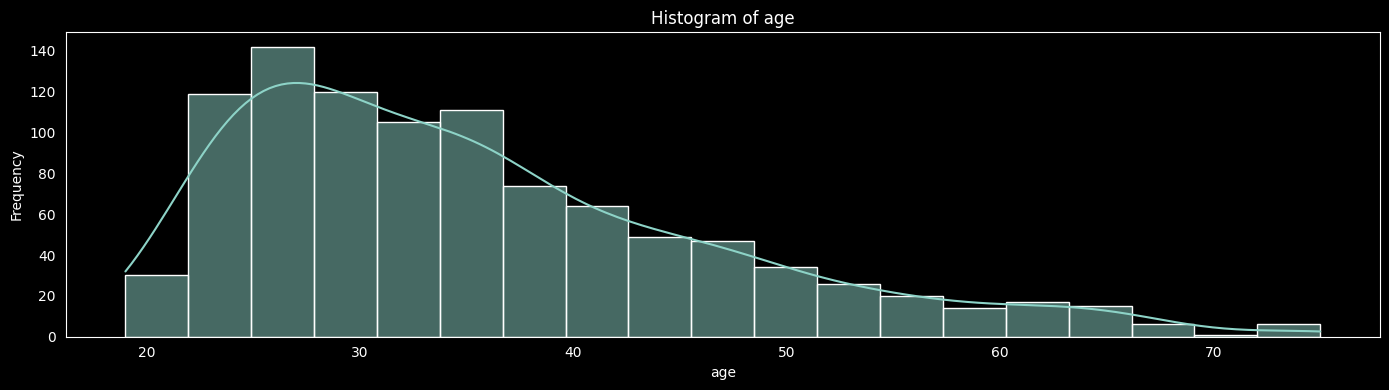

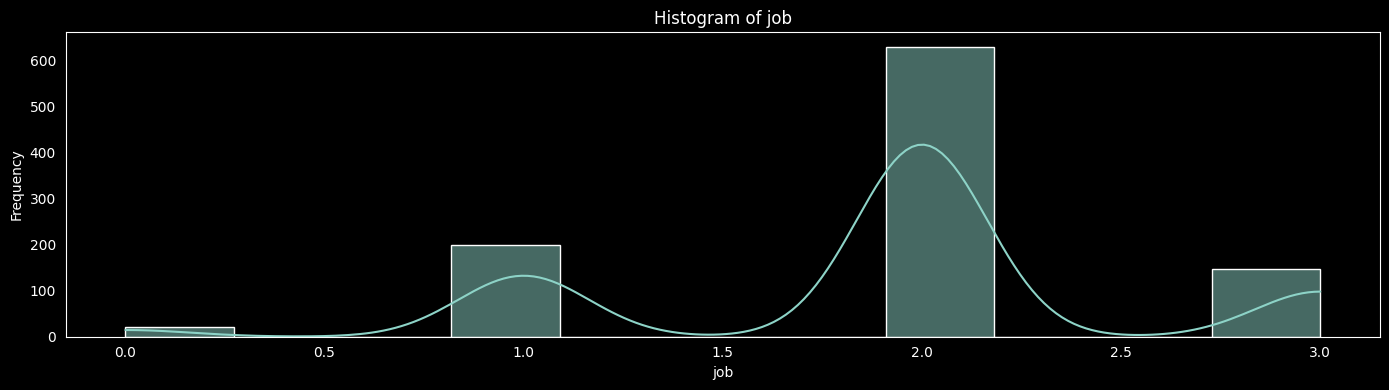

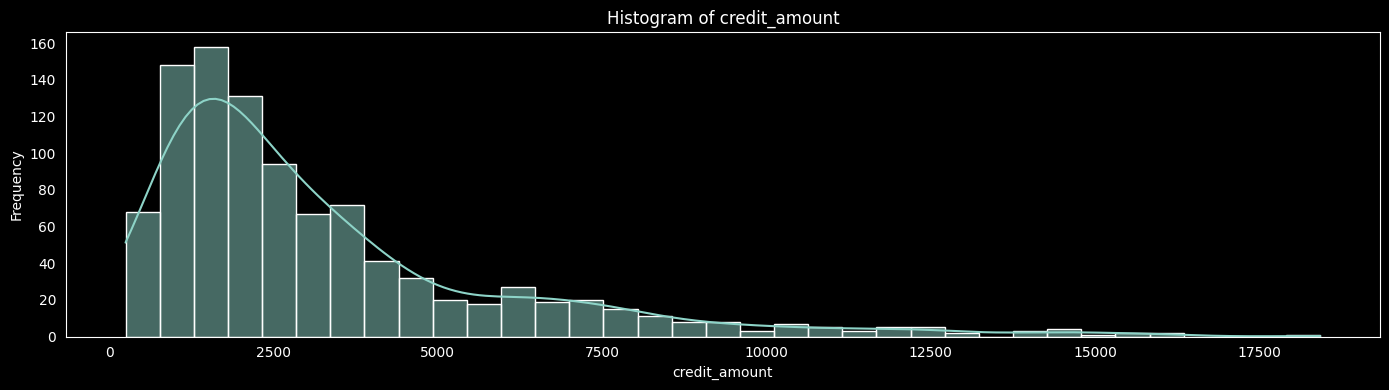

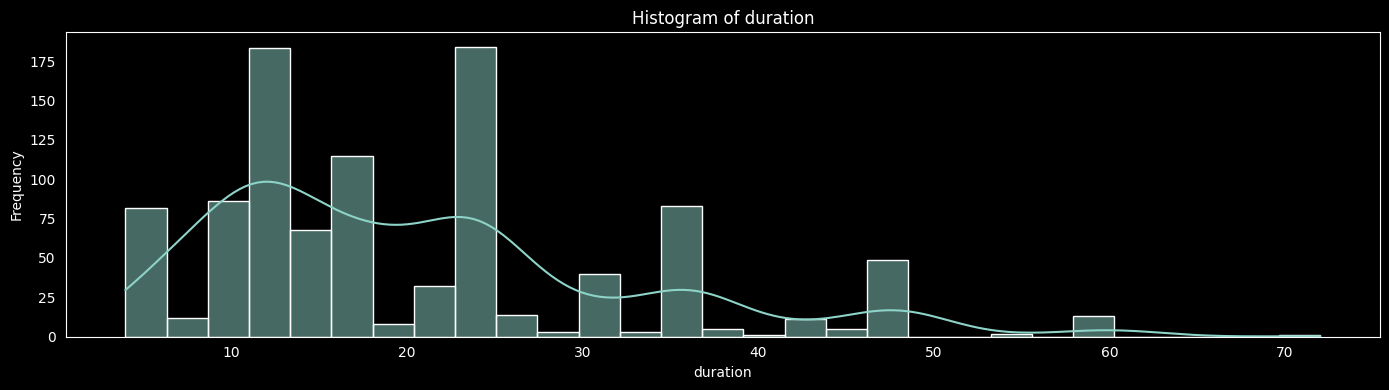

In [11]:
for col in numerical_columns:
    plt.figure(figsize=(14, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Summary 
#### Histogram of Age
- The tail is on the right, meaning that the data is right-skewed (positively skewed). 
- Right-skewed distributions have a longer tail on the right, indicating that there are fewer occurrences of higher values compared to lower values.
- Left-skewed (negatively skewed) distributions, on the other hand, have a longer tail on the left, meaning that there are fewer occurrences of lower values and more frequent higher values.

#### Histogram of Job
- A multimodal distribution has more than one peak, meaning that the data has multiple clusters or groups. In this case:

- There's a small peak around 0.
- A larger peak around 1.
- A very large peak around 2.
- Another smaller peak around 3.
- This suggests that the dataset consists of distinct groups of jobs, with job category 2 being the most common. 
- The presence of multiple peaks indicates that the data is not normally distributed and that different subpopulations may exist within the dataset.

#### Historgram of duration
- Irregular peaks, Instead of a smooth distribution, the histogram has distinct spikes at certain values (e.g., around 10 and 25).
- Gaps and dips, Some durations are far less frequent or even missing in between peaks, which isn’t typical for continuous data.
- Multimodal behaviour, There appear to be multiple peaks, suggesting different clusters or patterns in the data.
- These are likely loan durations so the peaks could represent common loan terms (e.g., 1 year, 2 years, 3 years, etc.). The spikes and gaps could be due to the way loans are typically structured (e.g., 12 months, 24 months, 36 months, etc.).

In [13]:
# Convert to categorical
df2 = df.copy()
df2["job"] = df2["job"].astype("object")
# df2["duration"] = df2["duration"].astype("object")

# Re-split the columns
categorical_columns = df2.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = df2.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']
Numerical Columns: ['age', 'credit_amount', 'duration']


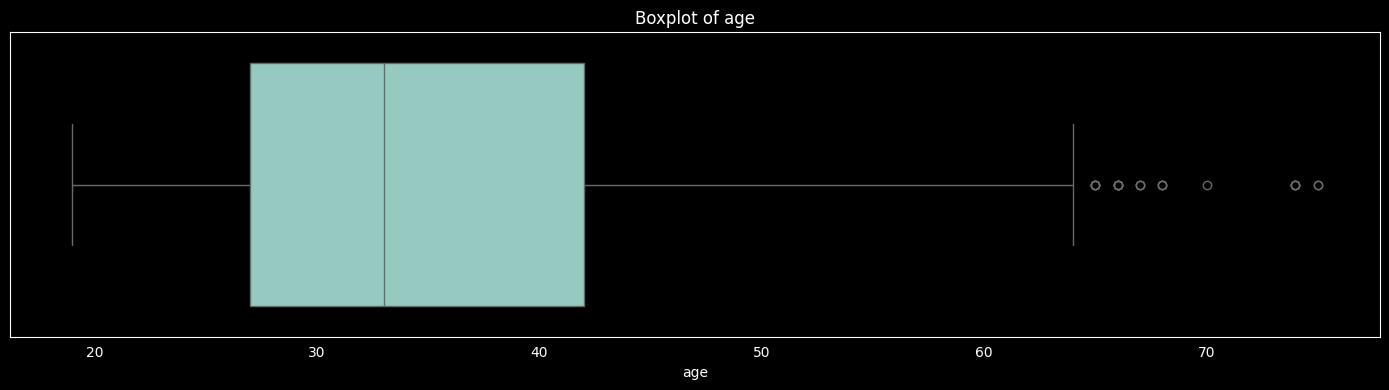

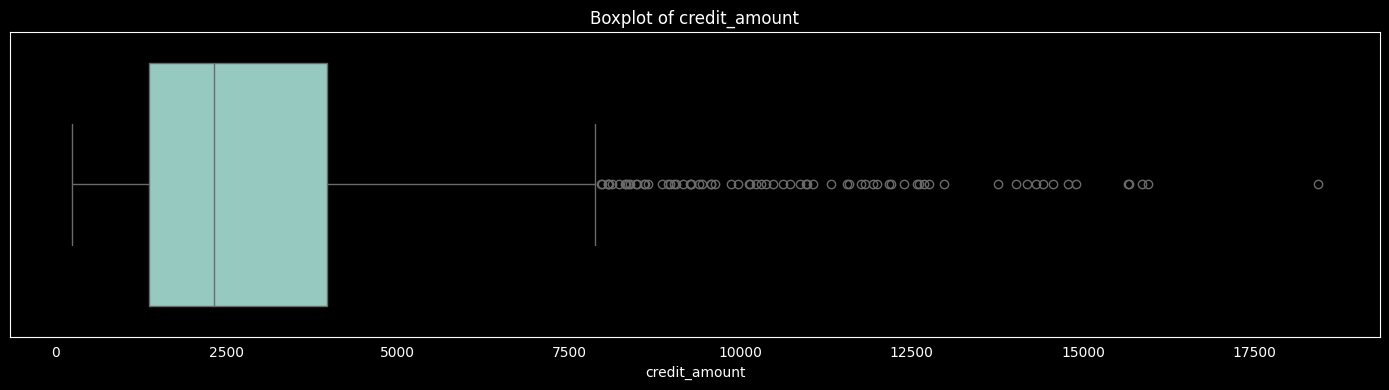

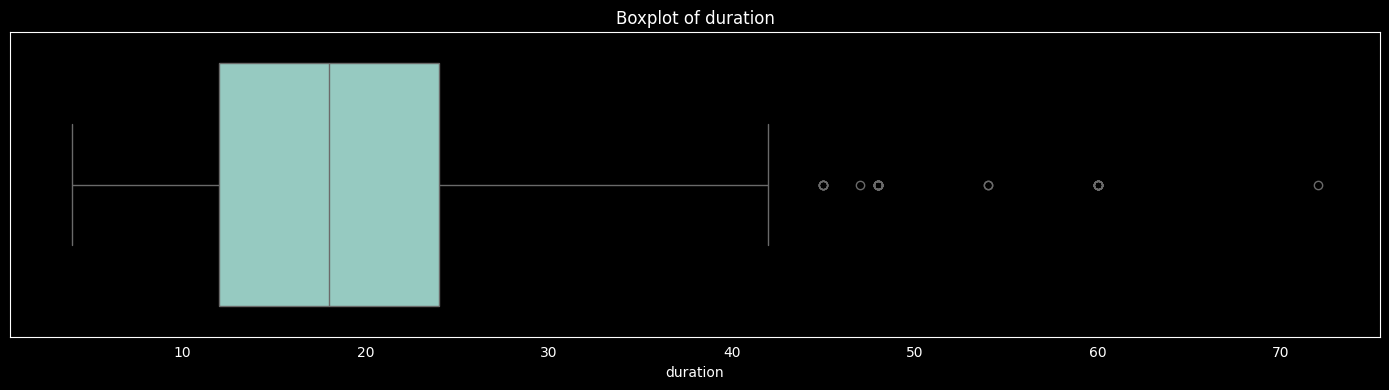

In [14]:
for col in numerical_columns:
    plt.figure(figsize=(14, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [16]:
df2["age"].median()

33.0

### Summary
##### Boxplot of Age
- The age distribution ranges from approximately 20 to 70 years.
- The median age appears to be around 30 years.
- There are no extreme outliers, indicating a relatively uniform age distribution.

### Boxplot of Credit Amount
- The credit amount varies significantly, ranging from 0 to around 17500.
- The median credit amount is approximately 2500.
- The presence of higher values suggests some outliers or individuals with significantly higher credit amounts.

### Boxplot of Duration
- The duration of credits ranges from about 10 to 70.
- The median duration is around 20.
- The distribution is relatively symmetrical, with no significant outliers.

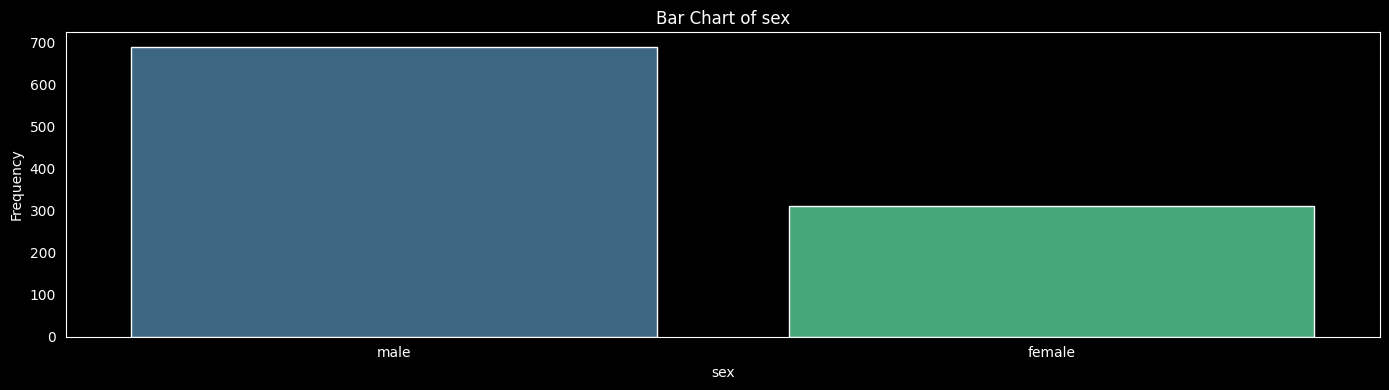

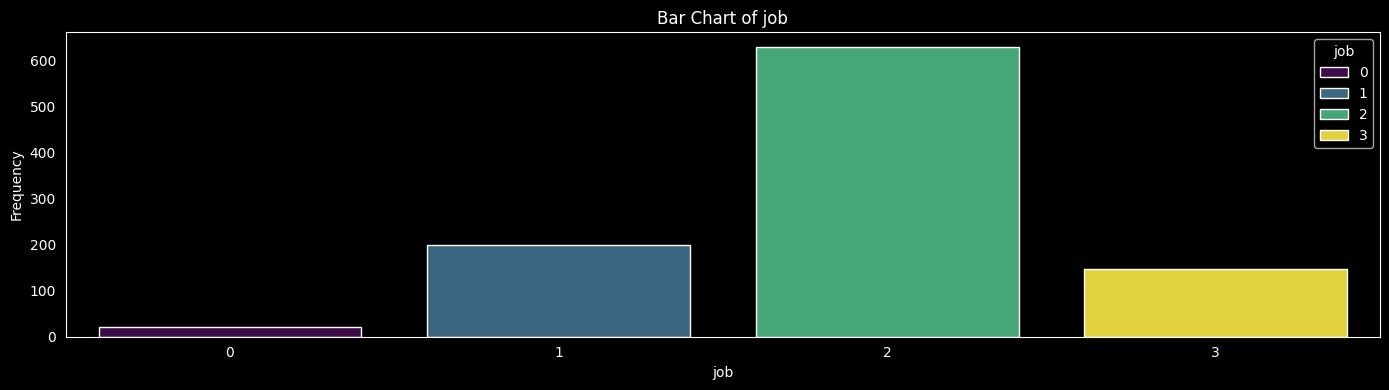

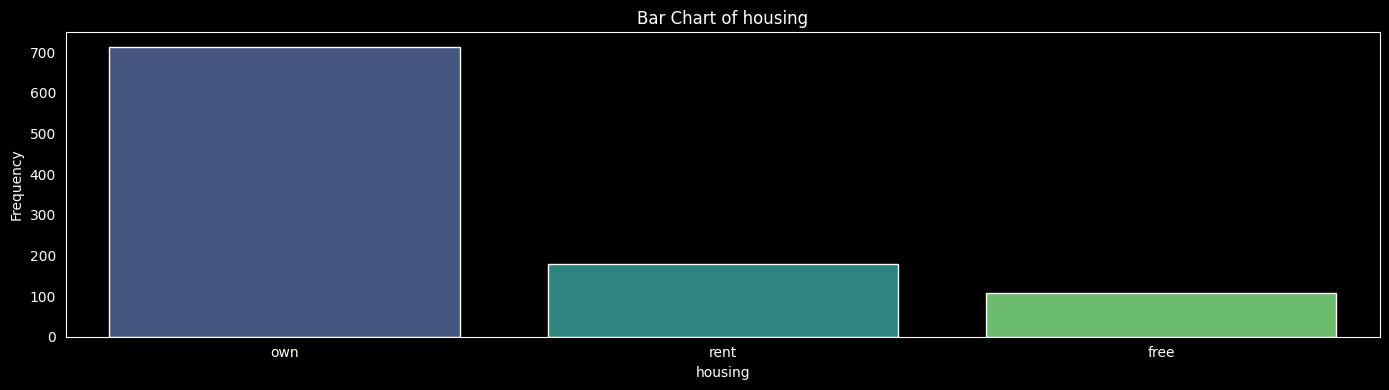

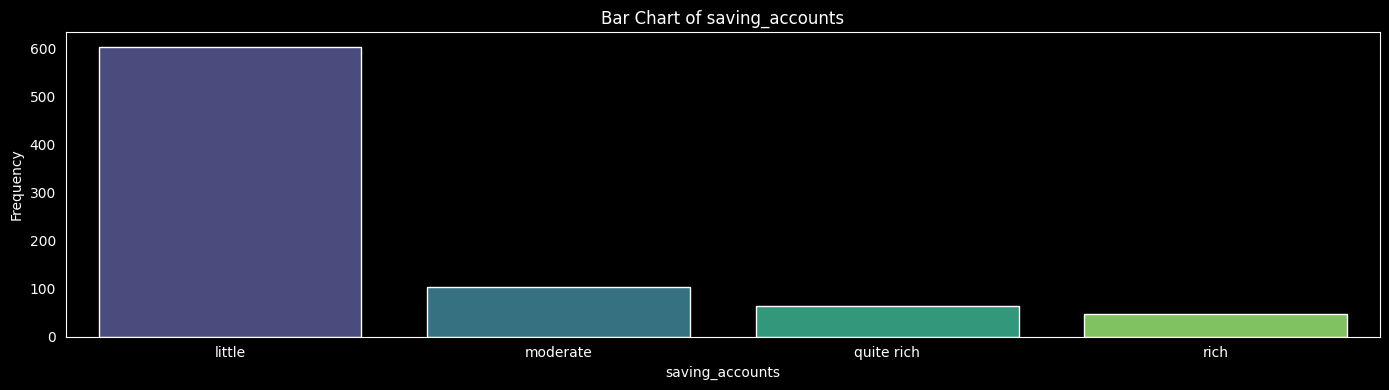

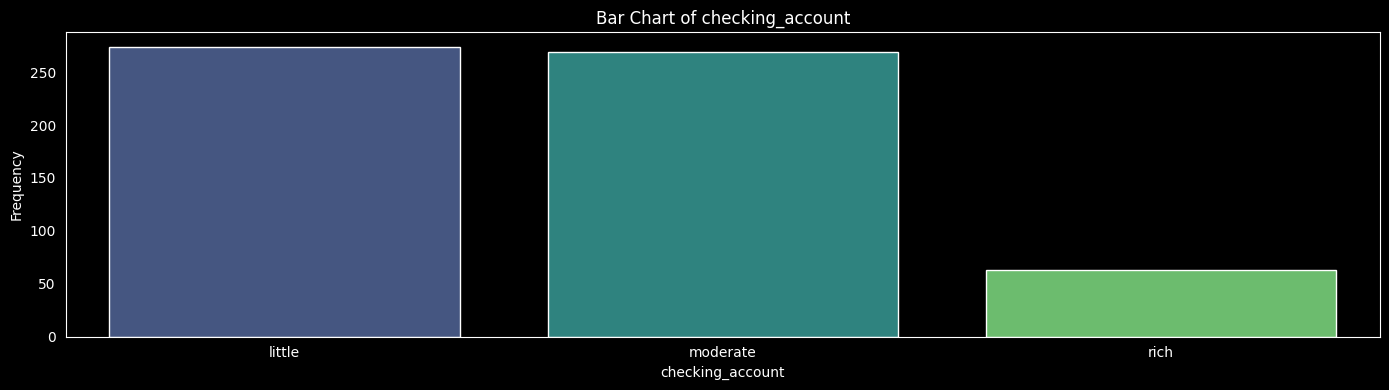

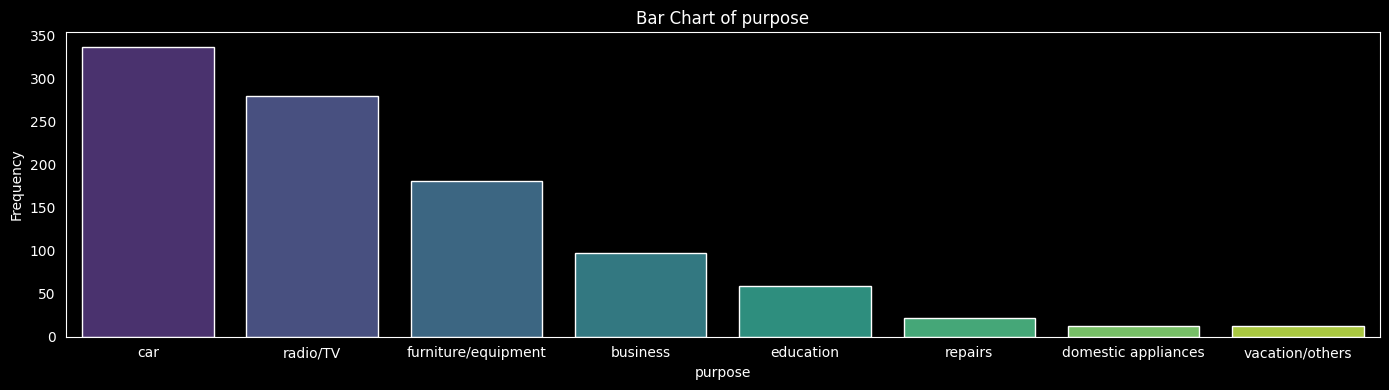

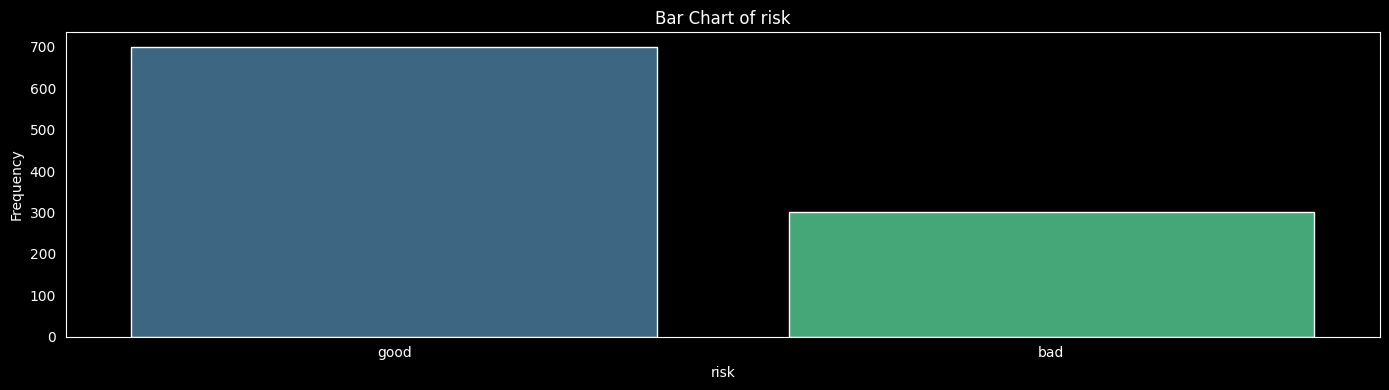

In [17]:
for col in categorical_columns:
    plt.figure(figsize=(14, 4))
    counts = df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="viridis")
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    # plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Bivariate Analysis

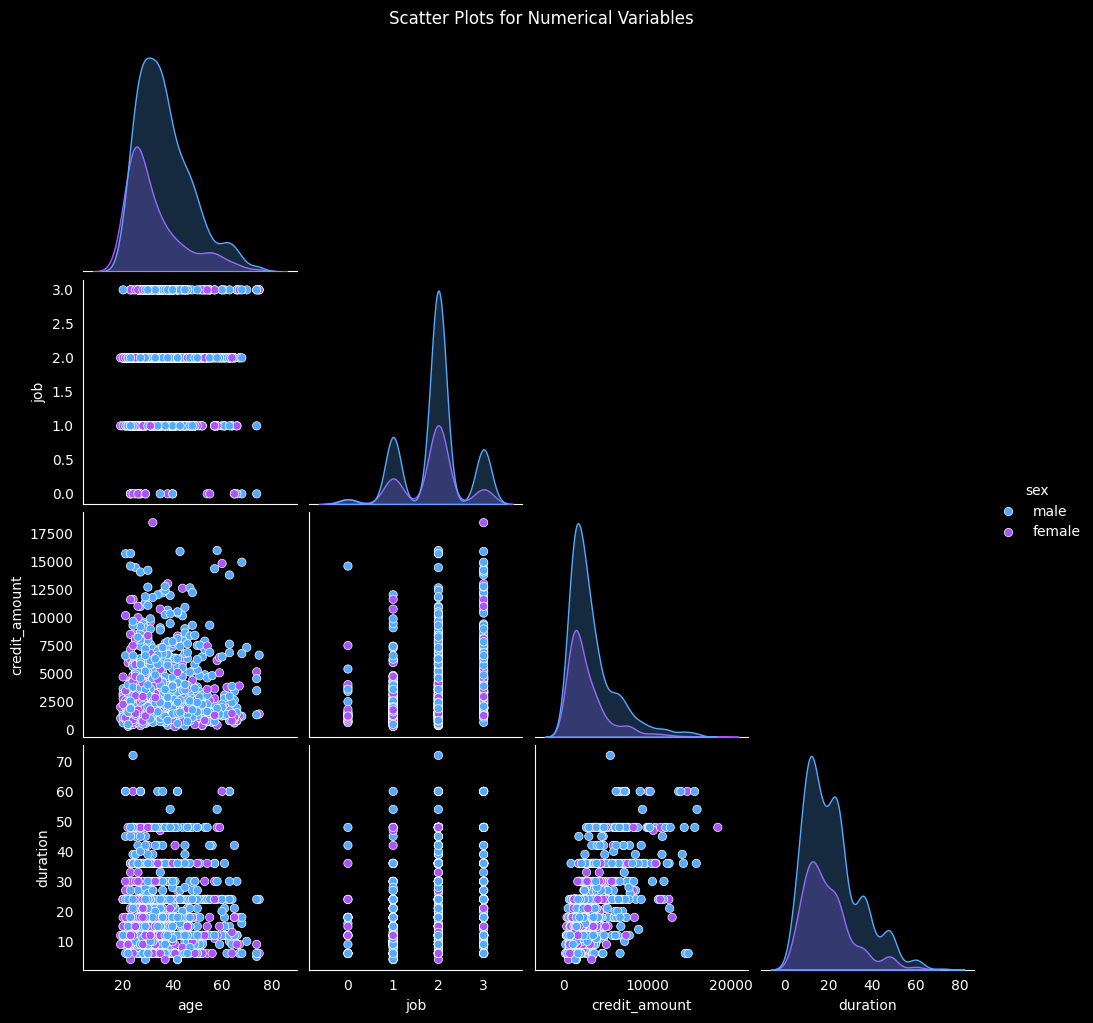

In [32]:
sns.pairplot(
    diag_kind="kde",
    hue="sex",
    palette="cool",
    corner=True,
    data=df2,
)
plt.suptitle("Scatter Plots for Numerical Variables", y=1.02)
plt.show()

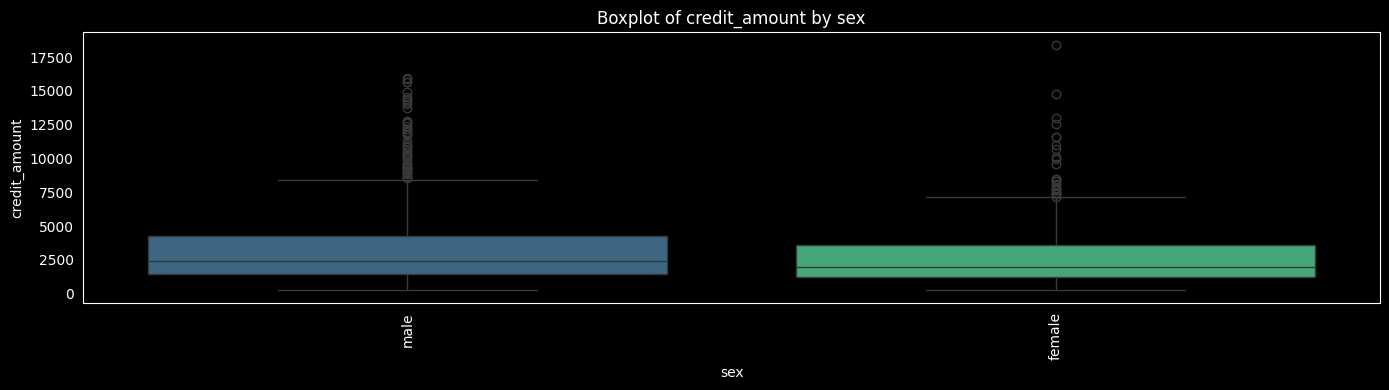

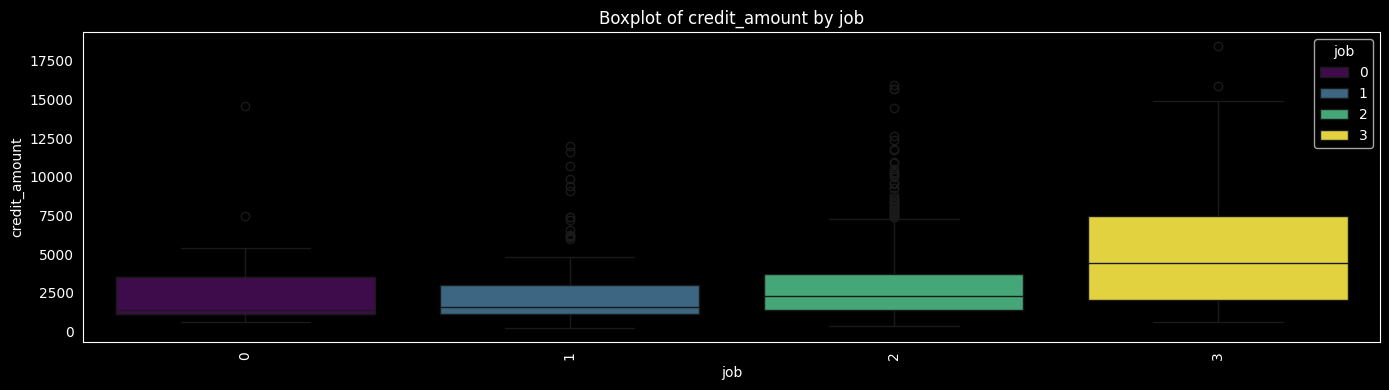

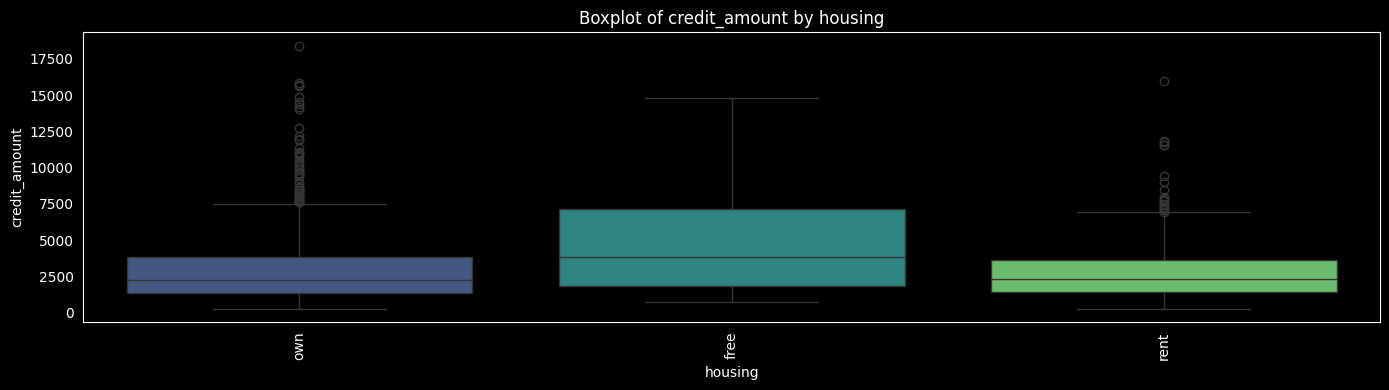

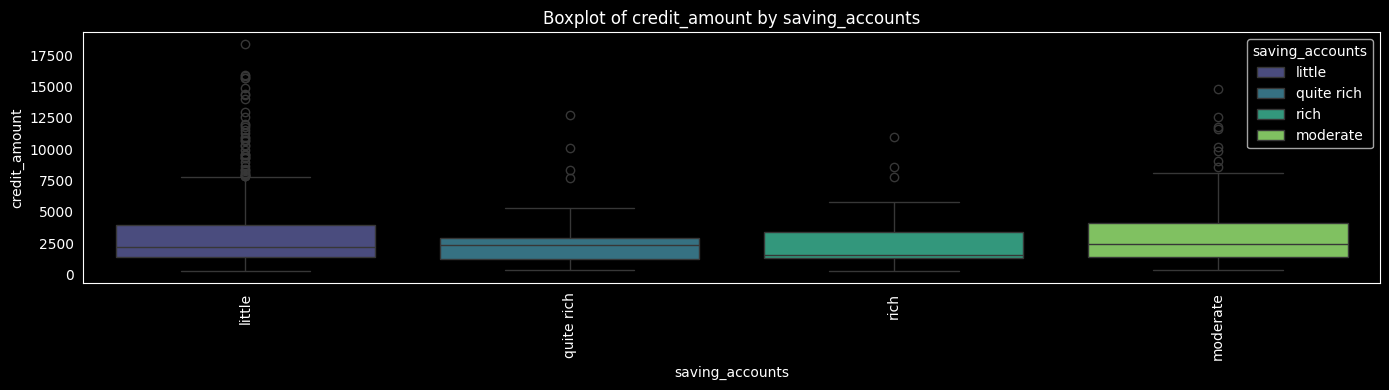

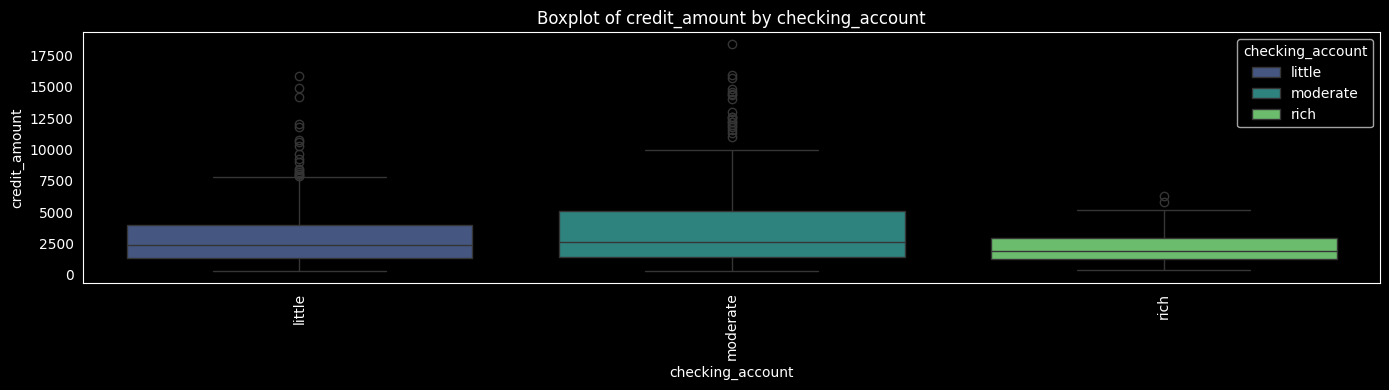

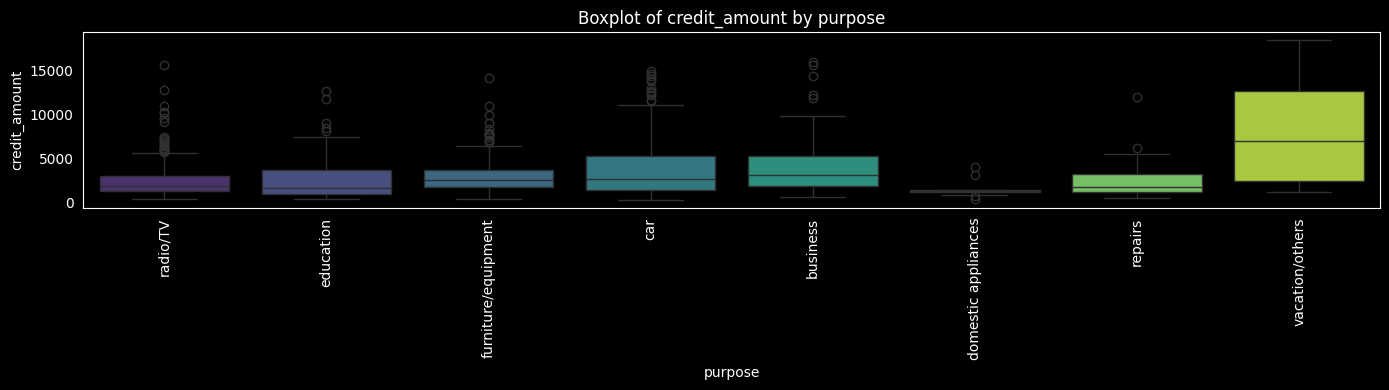

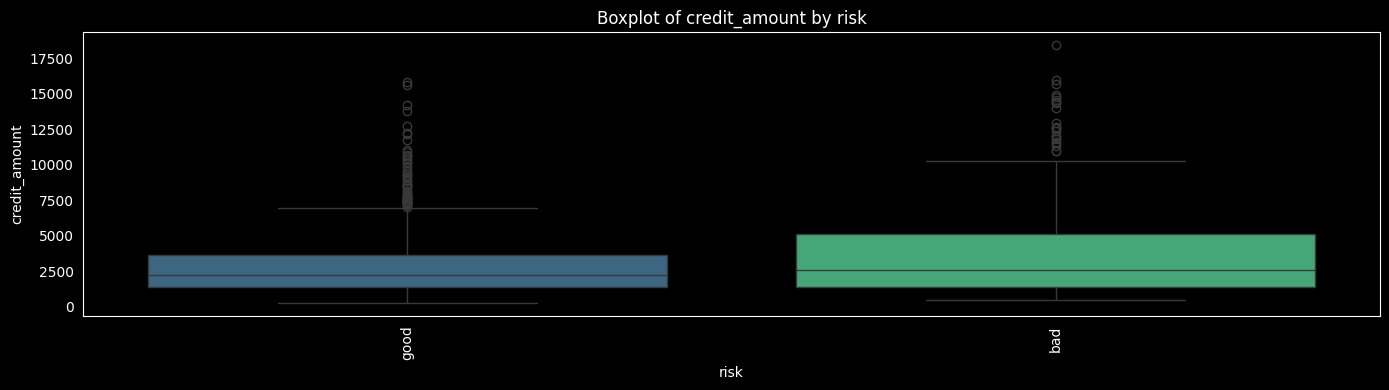

In [33]:
selected_numerical = "credit_amount"
for idx, cat in enumerate(categorical_columns):
    plt.figure(figsize=(14, 4))
    sns.boxplot(x=df2[cat], y=df2[selected_numerical], hue=df2[cat], palette="viridis")
    plt.title(f"Boxplot of {selected_numerical} by {cat}")
    plt.xlabel(cat)
    plt.ylabel(selected_numerical)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Summary  

#### Boxplot of credit_amount by job  
- Individuals with job category 3 tend to have higher credit amounts on average.  
- Job categories 0, 1, and 2 have similar credit distributions, with job category 3 having a higher median.  
- There are outliers in all job categories, especially in categories 2 and 3.  

#### Boxplot of credit_amount by housing  
- Those who own a house tend to have lower credit amounts on average.  
- Individuals with free housing have a higher median credit amount than those who rent or own.  
- Free housing has a wider range of credit amounts.  

#### Boxplot of credit_amount by purpose  
- Loans for vacations/others tend to have the highest credit amounts.  
- Business and car-related loans have a higher median credit amount than education and radio/TV.  
- Domestic appliances and repairs have the lowest credit amounts.  
- There are significant outliers across multiple loan purposes.  

#### Boxplot of credit_amount by risk  
- Individuals with bad credit risk tend to have higher credit amounts compared to those with good credit risk.  
- The median credit amount for bad risk is significantly higher than for good risk.  
- Both categories have several outliers, but bad risk has a wider distribution.  

### Hypothesis Testing: Credit Amount by Risk  

#### **T-Test (Comparing Means)**  
   - **H₀ (Null Hypothesis):** There is no difference in average **credit amount** between people with good and bad risk.  
   - **H₁ (Alternative Hypothesis):** People with bad risk have a significantly higher **credit amount** than those with good risk.  

#### **Test Choice:**  
   - Since **risk** is categorical (good/bad) and **credit amount** is numeric, a **two-sample independent T-test** is appropriate.  
   - This test will help determine if the difference in mean credit amounts is statistically significant.  


In [ ]:
# Split data into two groups
good_risk = df[df["risk"] == "good"]["credit_amount"]
bad_risk = df[df["risk"] == "bad"]["credit_amount"]

# Perform independent two-sample T-test
t_stat, p_value = stats.ttest_ind(
    bad_risk, good_risk, equal_var=False
)  # Welch’s T-test

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(
        "Reject the null hypothesis: People with bad risk have significantly different credit amounts."
    )
else:
    print(
        "Fail to reject the null hypothesis: No significant difference in credit amounts between good and bad risk groups."
    )

T-statistic: 4.2642
P-value: 0.0000
Reject the null hypothesis: People with bad risk have significantly different credit amounts.


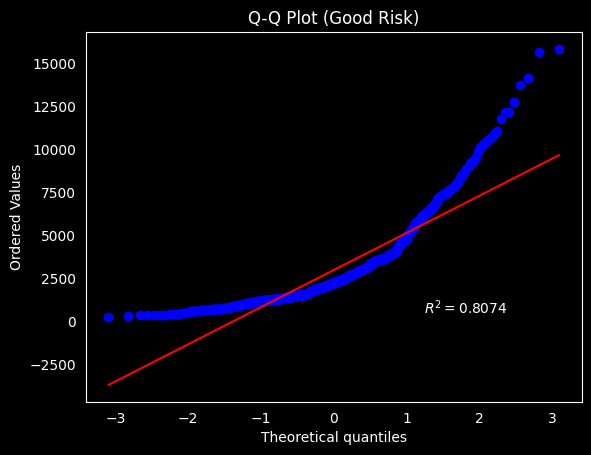

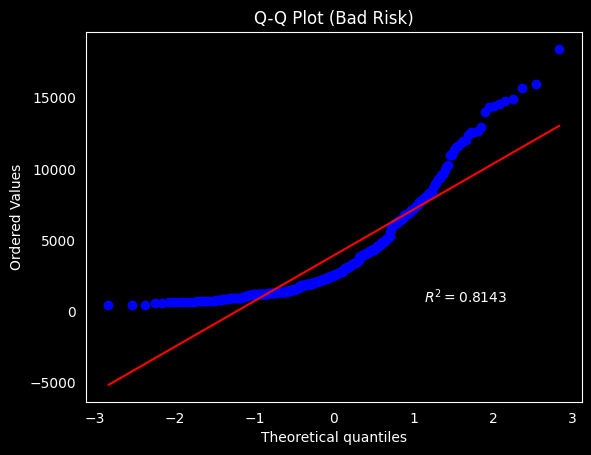

In [48]:
# Q-Q (Quantile-Quantile) Plot for Good Risk
stats.probplot(good_risk, dist="norm", plot=plt, rvalue=True)
plt.title("Q-Q Plot (Good Risk)")
plt.show()

# Q-Q (Quantile-Quantile) Plot for Bad Risk
stats.probplot(bad_risk, dist="norm", plot=plt,rvalue=True)
plt.title("Q-Q Plot (Bad Risk)")
plt.show()

In [ ]:
# p > 0.05 → Data is normal (T-test is fine).
# p ≤ 0.05 → Data is not normal (Consider Mann-Whitney U test).

stat, p_value = shapiro(good_risk)
print(f"Shapiro-Wilk Test (Good Risk): p = {p_value:.4f}")

stat, p_value = shapiro(bad_risk)
print(f"Shapiro-Wilk Test (Bad Risk): p = {p_value:.4f}")


Shapiro-Wilk Test (Good Risk): p = 0.0000
Shapiro-Wilk Test (Bad Risk): p = 0.0000


In [ ]:
# If skewness is between -1 and 1, it’s roughly normal.
# If skewness is >1 or <-1, it’s heavily skewed (consider Mann-Whitney).

print(f"Skewness (Good Risk): {good_risk.skew():.4f}")
print(f"Skewness (Bad Risk): {bad_risk.skew():.4f}")

Skewness (Good Risk): 1.9504
Skewness (Bad Risk): 1.5840


In [ ]:
stat, p = mannwhitneyu(good_risk, bad_risk, alternative='two-sided')

print(f"Mann-Whitney U Test Statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("Reject the null hypothesis: People with bad risk have significantly different credit amounts.")
else:
    print("Fail to reject the null hypothesis: No significant difference in credit amounts.")


Mann-Whitney U Test Statistic: 93480.0000
P-value: 0.0059
Reject the null hypothesis: People with bad risk have significantly different credit amounts.


In [53]:
median_good = good_risk.median()
median_bad = bad_risk.median()

print(f"Median Credit Amount (Good Risk): {median_good:.2f}")
print(f"Median Credit Amount (Bad Risk): {median_bad:.2f}")

if median_bad > median_good:
    print("People with bad risk tend to have higher credit amounts.")
else:
    print("People with bad risk tend to have lower credit amounts.")


Median Credit Amount (Good Risk): 2244.00
Median Credit Amount (Bad Risk): 2574.50
People with bad risk tend to have higher credit amounts.


In [43]:
# Calculate mean credit amounts for both groups
mean_good = good_risk.mean()
mean_bad = bad_risk.mean()

print(f"Mean credit amount (Good Risk): {mean_good:.2f}")
print(f"Mean credit amount (Bad Risk): {mean_bad:.2f}")

# Check which group has the higher mean
if mean_bad > mean_good:
    print("On average, people with bad risk have higher credit amounts.")
else:
    print("On average, people with good risk have higher credit amounts.")

Mean credit amount (Good Risk): 2985.46
Mean credit amount (Bad Risk): 3938.13
On average, people with bad risk have higher credit amounts.


/home/ubuntu/.cache/pypoetry/virtualenvs/kaggle-projects-l_2b9_F_-py3.10/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/.cache/pypoetry/virtualenvs/kaggle-projects-l_2b9_F_-py3.10/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


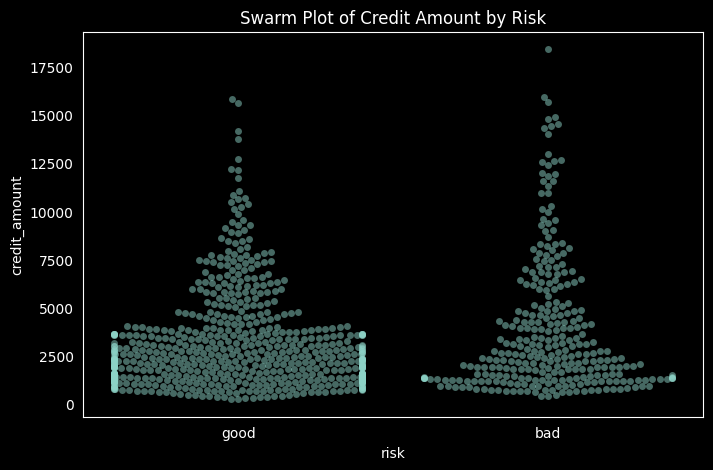

In [58]:
plt.figure(figsize=(8, 5))
sns.swarmplot(x=df['risk'], y=df['credit_amount'], alpha=0.5);
plt.title("Swarm Plot of Credit Amount by Risk")
plt.show()

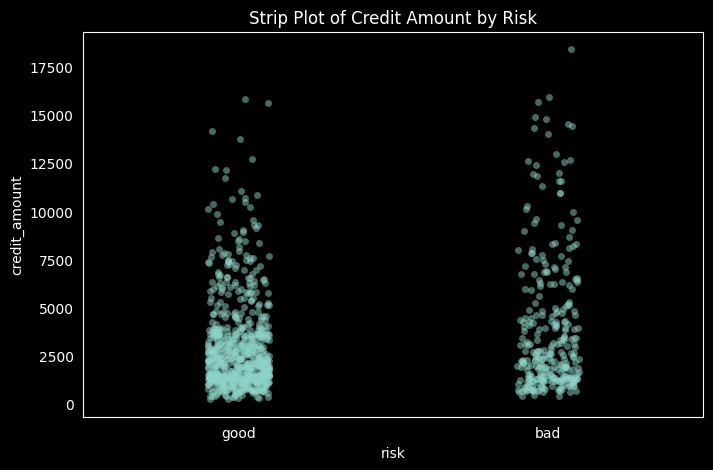

In [44]:
plt.figure(figsize=(8, 5))
sns.stripplot(x=df['risk'], y=df['credit_amount'], jitter=True, alpha=0.5)
plt.title("Strip Plot of Credit Amount by Risk")
plt.show()

In [36]:
categorical_columns

['sex',
 'job',
 'housing',
 'saving_accounts',
 'checking_account',
 'purpose',
 'risk']

In [34]:
# # Loop through all unique pairs of categorical variables
# for cat_var1, cat_var2 in itertools.combinations(categorical_columns, 2):
#     # Create a cross-tabulation of the two variables
#     crosstab = pd.crosstab(df[cat_var1], df[cat_var2])
    
#     # Plot a stacked bar chart
#     crosstab.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
#     plt.title(f"Stacked Bar Chart of {cat_var1} vs. {cat_var2}")
#     plt.xlabel(cat_var1)
#     plt.ylabel("Count")
#     plt.xticks(rotation=90)
#     plt.legend(title=cat_var2)
#     plt.tight_layout()
#     plt.show()

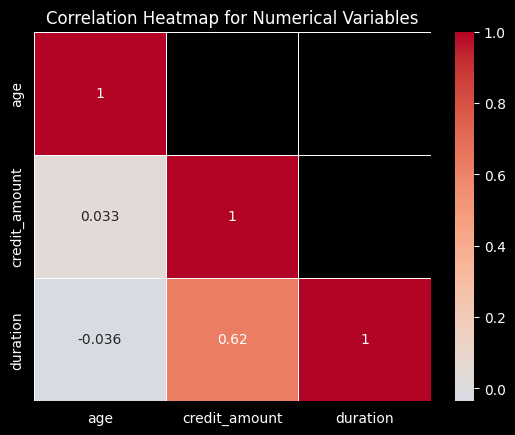

In [41]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = df[numerical_columns].corr(method="pearson")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    mask=mask,
    linewidths=0.7,
    center=0,
)
plt.title("Correlation Heatmap for Numerical Variables")
plt.show()